In [1]:
import json
import collections
import itertools
import copy
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import matplotlib
from scipy import stats
from scipy.misc import derivative

# Pval generation related functions, previously in the notebook
from booltest.pvals import *

In [2]:
def pvalue_comp(fnc, extremes, dx, bin_tup, by_bins=True):
    """Extremes = [(val, direction +1\-1)] """
    nints = len(extremes)
    areas = [0] * nints
    nbounds = [x[0] for x in extremes]
    nbins = [binize(x[0], bin_tup) for x in extremes]
    bmin = min(nbounds)
    bmax = max(nbounds)
    cp = 0
    iterc = 0
    results = []
    print('OK: ', nints, nbins, ' size: ', bin_tup[4])
    
    while cp <= 1.0:  # integration step
        iterc += 1
        if iterc > 10000:
            raise ValueError('exc')  # Hard-termination to avoid infinite cycle.
        
        # Integration by increasing pvalue and tabulating.
        # Each area grows at the same pace. pvalue is a sum of areas.
        # Termination - bounds are crossing / touching.
        
        # Integrate each area with one step but in such a way the area is the same. 
        max_area = max(areas)
        min_area = min(areas)
        sum_area = sum(areas)
        err = max([abs(x) for x in all_diffs(areas)])
        areas_str = ['%.7f' % x for x in areas]
        #print('Main iter: %s, cp: %.7f, mina: %.7f, maxa: %.7f, suma: %.7f, err: %.7f, a: [%s], n: %s' 
        #      % (iterc, cp, min_area, max_area, sum_area, err, ', '.join(areas_str), nbins))
        
        subit = 0
        while any([x <= min_area for x in areas]):
            subit += 1
            #print('.. subit: %s' % subit)
            
            for ix in range(nints):
                if areas[ix] > min_area :
                    continue
                if by_bins:
                    areas[ix] += get_bin_val(nbins[ix], bin_tup)
                    nbounds[ix] = get_bin_start(nbins[ix], bin_tup)
                    nbins[ix] = move_bound(nbins[ix], 1, extremes[ix][1])
                else:
                    areas[ix] += fnc(nbounds[ix])
                    nbounds[ix] = move_bound(nbounds[ix], dx, extremes[ix][1])        
        cp = sum(areas)
        
        crit_int = [None]*nints
        for i in range(nints):
            crit_int[i] = (extremes[i][0], nbounds[i]) if extremes[i][1] > 0 else (nbounds[i], extremes[i][0])
            
        results.append((cp, crit_int, copy.deepcopy(areas), err))
        
    #print('Main iter: %s, cp: %s, mina: %s, maxa: %s, suma: %s, a: %s' 
    #          % (iterc, cp, min(areas), max(areas), sum(areas), areas))
    #print('Total: %s' % (sum([get_bin_val(ix, bin_tup) for ix in range(len(bin_tup[0]))])))
    #print(json.dumps(results, indent=2))
    return results


def tabulate_pvals(val, nbins=200, abs_val=False, target_pvals=[0.0,0.0001,0.0005,0.001,0.005,0.01]):
    inp_iter = val['zscores']
    if abs_val:
        inp_iter = [abs(x) for x in inp_iter]
    
    bin_tup = get_bins(inp_iter, nbins=nbins, full=True)
    bb = get_distrib_fbins(inp_iter, bin_tup)
    
    bin_size = bin_tup[1]
    minv, maxv = bin_tup[2], bin_tup[3] 
    bins = np.array([x[0] for x in bb])
    
    # Tabulate pvalues
    # build_integrator(bin_tup)
    extremes = [
        [minv, 1],
        [0, -1],
        [0, +1],
        [maxv, -1]
    ] if not abs_val else [
        [minv, 1],
        [maxv, -1]
    ]
    
    print('%s-%s-%s-%s-%s' % (val['method'], val['block'], val['deg'], val['comb_deg'], val['data_size']))
    pvals = pvalue_comp(lambda x: binned_pmf(x, bin_tup), extremes, 
                        dx=1./(nbins/10.), bin_tup=bin_tup, by_bins=True)

    res_pdata = []
    for target in target_pvals:
        chosen = 0
        for i in range(len(pvals)):
            chosen = i
            if pvals[i][0] >= target:
                chosen = i - 1 if i > 0 else 0
                break
                
        cdata = pvals[chosen]
        res_pdata.append(collections.OrderedDict([
            ('pval_target', target),
            ('pval', cdata[0]),
            ('crit', cdata[1]),
            ('areas', cdata[2]),
            ('err', cdata[3]),
        ]))

    return collections.OrderedDict([
        ('method', val['method']), 
        ('block', val['block']),
        ('deg', val['deg']),
        ('comb_deg', val['comb_deg']),
        ('data_size', val['data_size']),
        ('nsamples', len(inp_iter)),
        ('nbins', nbins),
        ('abs_val', abs_val),
        ('binsize', bin_size),
        ('minv', minv),
        ('maxv', maxv),
        ('extremes', extremes),
        ('pvals', res_pdata)
    ])


In [3]:
#js = json.load(open('ref_1554219251.json'))
#csv = open('ref_1554219251.csv').read()
csv = open('ref_1558361146.csv').read()

csv_data = []
for rec in [x.strip() for x in csv.split("\n")]:
    p = rec.split(';')
    if len(p) < 6:
        continue
    cur = collections.OrderedDict([
        ('method', p[0]), 
        ('block', int(p[1])),
        ('deg', int(p[2])),
        ('comb_deg', int(p[3])),
        ('data_size', int(p[4])),
        ('zscores', [float(x.replace(',','.')) for x in p[6:]])
    ])
    csv_data.append(cur)
print(json.dumps(csv_data[0]))  

{"method": "in0-kctr-ri1", "block": 128, "deg": 1, "comb_deg": 2, "data_size": 10, "zscores": [-3.77991]}


In [4]:
data = csv_data
data_filt = [x for x in data if x and len(x['zscores']) > 1000]
data_filt.sort(key=lambda x: (x['method'], x['block'], x['deg'], x['comb_deg'], x['data_size']))
np.random.seed(87655677)

In [5]:
pval_db = []
for dix, val in enumerate(data_filt):
    res = tabulate_pvals(val, abs_val=True)
    pval_db.append(res)
    print('Dump %s' % dix)
json.dump(pval_db, open('pval_db.json', 'w+'), indent=2)

inctr-krnd-ri0-128-1-1-10
OK:  2 [0, 153]  size:  20000
Dump 0
inctr-krnd-ri0-128-1-2-10
OK:  2 [0, 146]  size:  19999
Dump 1
inctr-krnd-ri0-128-1-3-10
OK:  2 [0, 138]  size:  20000
Dump 2
inctr-krnd-ri0-128-2-1-10
OK:  2 [0, 149]  size:  20000
Dump 3
inctr-krnd-ri0-128-2-2-10
OK:  2 [0, 147]  size:  20000
Dump 4
inctr-krnd-ri0-128-2-3-10
OK:  2 [0, 143]  size:  20001
Dump 5
inctr-krnd-ri0-128-3-1-10
OK:  2 [0, 144]  size:  20000
Dump 6
inctr-krnd-ri0-128-3-2-10
OK:  2 [0, 139]  size:  20001
Dump 7
inctr-krnd-ri0-128-3-3-10
OK:  2 [0, 145]  size:  20001
Dump 8
inctr-krnd-ri0-256-1-1-10
OK:  2 [0, 148]  size:  20000
Dump 9
inctr-krnd-ri0-256-1-2-10
OK:  2 [0, 149]  size:  19999
Dump 10
inctr-krnd-ri0-256-1-3-10
OK:  2 [0, 149]  size:  20000
Dump 11
inctr-krnd-ri0-256-2-1-10
OK:  2 [0, 144]  size:  20001
Dump 12
inctr-krnd-ri0-256-2-2-10
OK:  2 [0, 142]  size:  20000
Dump 13
inctr-krnd-ri0-256-2-3-10
OK:  2 [0, 144]  size:  20000
Dump 14
inctr-krnd-ri0-256-3-1-10
OK:  2 [0, 141]  size:  

inhw6-krnd-ri0-256-1-3-10
OK:  2 [0, 138]  size:  20000
Dump 135
inhw6-krnd-ri0-256-2-1-10
OK:  2 [0, 146]  size:  20000
Dump 136
inhw6-krnd-ri0-256-2-2-10
OK:  2 [0, 149]  size:  20000
Dump 137
inhw6-krnd-ri0-256-2-3-10
OK:  2 [0, 141]  size:  20000
Dump 138
inhw6-krnd-ri0-256-3-1-10
OK:  2 [0, 138]  size:  20000
Dump 139
inhw6-krnd-ri0-256-3-2-10
OK:  2 [0, 135]  size:  20000
Dump 140
inhw6-krnd-ri0-256-3-3-10
OK:  2 [0, 138]  size:  20000
Dump 141
inhw6-krnd-ri0-384-1-1-10
OK:  2 [0, 152]  size:  20000
Dump 142
inhw6-krnd-ri0-384-1-2-10
OK:  2 [0, 143]  size:  20000
Dump 143
inhw6-krnd-ri0-384-1-3-10
OK:  2 [0, 137]  size:  20000
Dump 144
inhw6-krnd-ri0-384-2-1-10
OK:  2 [0, 147]  size:  20000
Dump 145
inhw6-krnd-ri0-384-2-2-10
OK:  2 [0, 146]  size:  20000
Dump 146
inhw6-krnd-ri0-384-2-3-10
OK:  2 [0, 145]  size:  20000
Dump 147
inhw6-krnd-ri0-384-3-1-10
OK:  2 [0, 134]  size:  20000
Dump 148
inhw6-krnd-ri0-384-3-2-10
OK:  2 [0, 136]  size:  20000
Dump 149
inhw6-krnd-ri0-384-3-3-10

inctr-krnd-ri0[128:1:1:10]: 20000 
<class 'scipy.stats._distn_infrastructure.rv_discrete'>
[0. 0. 0.]
[5.0e-05 1.0e-04 1.5e-04]
OK:  2 [0, 153]  size:  20000
inctr-krnd-ri0[128:1:1:10]: 20000 [4.92043868 4.40457212 3.93169444 3.52330008 3.32985012 2.77099468
 0.760756   5.04940532 1.80374488 1.91121708 2.36260032 3.32985012]


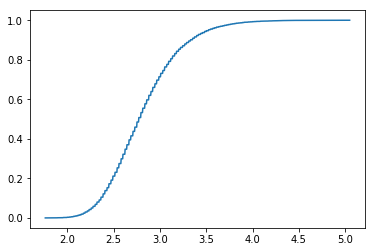

Plotting area under:  (0.01445, [(1.760756, 2.06167816), (4.03916664, 5.059644)], [0.00785, 0.0066], 0.001899999999999999)


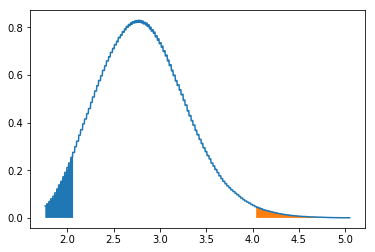

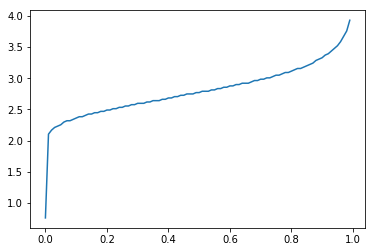

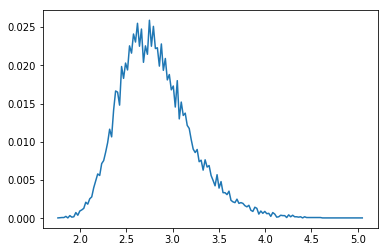

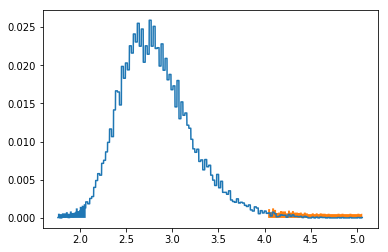

In [6]:
nbins = 200
abs_val = True
    
for dix, val in enumerate(data_filt):
    inp_iter = (val['zscores'])
    if abs_val:
        inp_iter = [abs(x) for x in inp_iter]
    
    print('%s[%s:%s:%s:%s]: %s %s' 
          % (val['method'], val['block'], val['deg'], val['comb_deg'], 
             val['data_size'], len(val['zscores']),
             '',#dst.ppf([1-0.0001, 1-0.001, 1-0.01, 1-0.05, 1-0.10, 1-0.5, 0, 1, 0.0001, 0.001, 0.1, 0.9])
             #dst.stats(moments='mvsk')
            ))
    
    bin_tup = get_bins(inp_iter, nbins=nbins, full=True)
    bb = get_distrib_fbins(inp_iter, bin_tup)
    
    bin_size = bin_tup[1]
    minv, maxv = bin_tup[2], bin_tup[3] 
    bins = np.array([x[0] for x in bb])
    dst = stats.rv_discrete(values=([x[0] for x in bb], [x[1] for x in bb]))
    print(stats.rv_discrete)
    
    x=np.array([bins[0], bins[1], bins[6]])
    print(dst.pmf(x))
    print(dst._pmf(x))
    
    # Tabulate pvalues
    build_integrator(bin_tup)
    extremes = [
        [minv, 1],
        [0, -1],
        [0, +1],
        [maxv, -1]
    ] if not abs_val else [
        [minv, 1],
        [maxv, -1]
    ]
    
    pvals = pvalue_comp(lambda x: binned_pmf(x, bin_tup), extremes, 
                        dx=1./(nbins/10.), bin_tup=bin_tup, by_bins=True)
    
    n_sample = 100
    rvs = dst.rvs(size=n_sample)
    f, l = np.histogram(rvs, bins=bins)
    f = np.append(f, [0])
    probs = np.array([x[1] for x in bb])
    #print(bins, len(bins))
    #print(probs, len(probs))
    #print(f, len(f))
    #sfreq = np.vstack([np.array([x[0] for x in bb]), f, probs*n_sample]).T
    #print(sfreq)
    
    print('%s[%s:%s:%s:%s]: %s %s' 
          % (val['method'], val['block'], val['deg'], val['comb_deg'], 
             val['data_size'], len(val['zscores']),
             dst.ppf([1-0.0001, 1-0.001, 1-0.01, 1-0.05, 1-0.10, 1-0.5, 0, 1, 0.0001, 0.001, 0.1, 0.9])
             #dst.stats(moments='mvsk')
            ))
    
    x = np.linspace(min(bins),max(bins),1000)
    plt.plot(x, dst.cdf(x))
    plt.show()
    
    cdf_dev = derivative(dst.cdf, x, dx=0.5)
    plt.plot(x,cdf_dev)
    
    sec_x = pvals[40]  # 49
    print('Plotting area under: ', sec_x)
    for ix in range(len(sec_x[1])):
        section = np.arange(sec_x[1][ix][0], sec_x[1][ix][1], 1/20.)
        plt.fill_between(section, derivative(dst.cdf, section, dx=0.5))
    plt.show()
    
    #for pv in pvals:
    #    sec_x = pv
    #    for ix in range(len(sec_x[1])):
    #        section = np.arange(sec_x[1][ix][0], sec_x[1][ix][1], 1/20.)
    #        plt.fill_between(section, derivative(dst.cdf, section, dx=0.5))
    #    plt.show()
    
    x = np.linspace(0,100,10000)
    plt.plot(x,dst.ppf(x))
    plt.show()
    
    x = np.linspace(minv,maxv,10000)
    plt.plot(bins, dst._pmf(bins))
    plt.show()
    
    x = np.linspace(minv,maxv,10000)
    plt.plot(x, [binned_pmf(y, bin_tup) for y in x])
    for ix in range(len(sec_x[1])):
        section = np.linspace(sec_x[1][ix][0], sec_x[1][ix][1], 10000) #np.arange(sec_x[1][ix][0], sec_x[1][ix][1], 1/20.)
        plt.fill_between(section, [binned_pmf(y, bin_tup)+0.0005 for y in section])
    plt.show()
    
    # Idea: pvalue function = pms of the distribution. 
    # If test returns z-score with p=0 then we reject the hypothesis as we didnt get such zscore
    # If test returns with p=0.3 we dont reject as we have our alpha set somehow...
    # Problem: number of bins. If too many, we have small probabilities -> some alphas not reachable.
    #if dix > 3:
    break
    

In [7]:
np.arange(7)
#np.zeros(np.shape(0.5),'d')
#print(dst.ppf([1-0.01, 1-0.05, 1-0.10, 0.5, 0.6]))

array([0, 1, 2, 3, 4, 5, 6])

In [8]:
# Compute pvalues
def compute_pvals(dset):
    zs = sorted()
    pass

20000
19999
20000
20000
20000


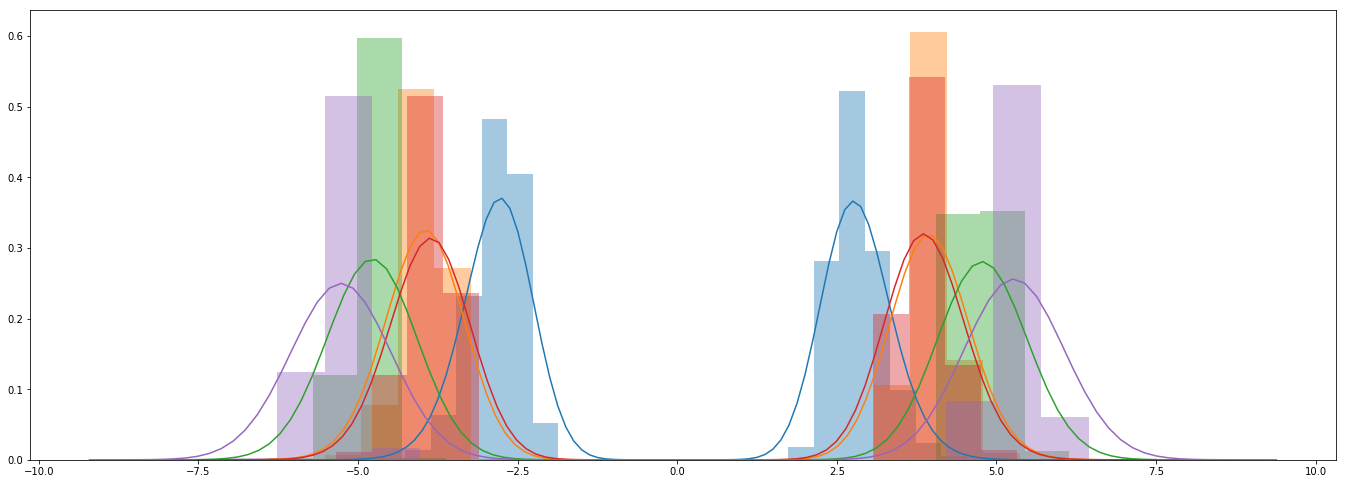

In [12]:
a4_dims = (2*11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
zs = data_filt[1]['zscores']

for  i in range(5):
    zs = [(x) for x in data_filt[i]['zscores']]
    print(len(zs))
    sns.distplot(a=zs, ax=ax, hist=True, norm_hist=False, bins='auto')

# pvalues
 - pvalue = probability (in the null hypothesis distribution) to be observed as a value equal to or more extreme than the value observed
 
## computation 
 - Derive CDF -> find 0 regions = extremes
 - Integrate from 0 regions towards region of increasing integral value. 
 - Once sum of all integrations is alpha, stop. Integrated area is a critical region
 - Computation for x: integrate until the first integral boundary hits x. pvalue = sum of integrals
 - Tabulation: for each desired pvalue compute boundaries (4 values) where critical region starts. 
 - pvalue(x): need to do the integration OR function table (\forall zscores: P(zscore) > 0).
 - In our case 4 extremes, integrate: 
   - -\inf towards 0
   - +\inf towards 0
   - 0 towards +\inf
   - 0 towards -\inf
   - 10000 samples, pvalue = 0 -> 1/10000. 
 - absolutize -> we have a new distribution -> 2x more datapoints, 2 tails.  
  

In [ ]:
np.arange(-1, 1, 1/20.)

In [ ]:
counter = [0] * 8
MAXV = 2

def inc(counter):
    global MAXV
    ln = len(counter) - 1
    while ln >= 0:
        counter[ln] = (counter[ln] + 1) % MAXV
        if (counter[ln] != 0):
            return(counter)
        ln-=1
    raise ValueError('Overflow')

    
def dec(counter):
    global MAXV
    ln = len(counter) - 1
    while ln >= 0:
        counter[ln] = (counter[ln] - 1) % MAXV
        if (counter[ln] != MAXV-1):
            return counter
        ln-=1
    raise ValueError('Underflow')
    
    
for i in range(20):
    print(inc(counter))
print('-'*80)
for i in range(20):
    print(dec(counter))

In [ ]:
from booltest import common


In [ ]:
common.generate_seed(2)

In [ ]:
import os
import time
tmp_files = os.scandir('/tmp')
for i in tmp_files:
    print(i)
    time.sleep(10)

In [ ]:
3*3*3*10000*3
